In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np



# Load INS data
ins_data = pandas.read_csv('csv/3-vectornav-ins.csv')
ins_data = ins_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
ins_data['time'] = pandas.to_datetime(ins_data['time'])
ins_data['time'] = (ins_data['time'] - ins_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
ins_data = ins_data.set_index('time')

# Load GPS Fix (raw) data
fix_data = pandas.read_csv('csv/3-vectornav-fix.csv')
fix_data = fix_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
fix_data['time'] = pandas.to_datetime(fix_data['time'])
fix_data['time'] = (fix_data['time'] - fix_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
fix_data = fix_data.set_index('time')



# Load IMU Data
imu_data = pandas.read_csv('csv/3-vectornav-imu.csv') 
imu_data = imu_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
imu_data['time'] = pandas.to_datetime(imu_data['time'])
imu_data['time'] = (imu_data['time'] - imu_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
imu_data = imu_data.set_index('time')


# Load Pacmod Speed Data
# pacmod parsed_txt/vehicle_speed is gets corrupt rows, so we will use as_tx/vehicle_speed
pacmod_speed = pandas.read_csv('csv/3-pacmod-as_tx-vehicle_speed.csv')
pacmod_speed['time'] = pandas.to_datetime(pacmod_speed['time'])
pacmod_speed['time'] = (pacmod_speed['time'] - pacmod_speed['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
# Additionally, there is an factor offset between parsed_txt/vehicle_speed and as_tx/vehicle_speed for whatever reason
# Use 2.237
pacmod_speed['.data'] = pacmod_speed['.data']*2.237
pacmod_speed = pacmod_speed.set_index('time')

# Load Pacmod Steer Data
pacmod_steer = pandas.read_csv('csv/3-pacmod-parsed_tx-steer_rpt.csv')
pacmod_steer = pacmod_steer.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
pacmod_steer['time'] = pandas.to_datetime(pacmod_steer['time'])
pacmod_steer['time'] = (pacmod_steer['time'] - pacmod_steer['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
pacmod_steer = pacmod_steer.set_index('time')

In [2]:
# Add some basic calculations to dataframes ...

# Mangitude of speed
ins_data['.mag_speed'] = (ins_data['.NedVel.y']**2 + ins_data['.NedVel.x']**2)**(1/2)

# ENU Frame - subtract 90 from yaw
yaw = (90 - ins_data['.RPY.z']) * np.pi/180
ins_x_vel = ins_data['.NedVel.y'] 
ins_y_vel = ins_data['.NedVel.x'] 

# Local velocity at IMU location
ins_data['.LocalVel.x'] = np.multiply(ins_x_vel,np.cos(yaw)) + np.multiply(ins_y_vel,np.sin(yaw))
ins_data['.LocalVel.y'] = -np.multiply(ins_x_vel,np.sin(yaw)) + np.multiply(ins_y_vel,np.cos(yaw))
del yaw, ins_x_vel, ins_y_vel # clear unused variables
ins_data.head()

,.header.seq,.header.frame_id,.Time,.Week,.Status,.RPY.x,.RPY.y,.RPY.z,.LLA.x,.LLA.y,...,.YawUncertainty,.PitchUncertainty,.RollUncertainty,.PosUncertainty,.VelUncertainty,.SyncInTime,.SyncInCount,.mag_speed,.LocalVel.x,.LocalVel.y
time,,,,,,,,,,,,,,,,,,,,,
0.000000,23995,vectornav,1.266946e+09,2094,33542,2.057272,-0.739279,5.663654,30.67242,-96.372515,...,0.309178,0.067305,0.067281,0.737166,0.095215,1.582908e+09,0,0.008869,0.005360,-0.007066
0.019065,23996,vectornav,1.266946e+09,2094,33542,2.058434,-0.738239,5.663603,30.67242,-96.372515,...,0.309263,0.067389,0.067364,0.738043,0.095509,1.582908e+09,0,0.008666,0.005406,-0.006773
0.039128,23997,vectornav,1.266946e+09,2094,774,2.058925,-0.737752,5.663154,30.67242,-96.372515,...,0.309349,0.067472,0.067448,0.738924,0.095803,1.582908e+09,0,0.008481,0.005204,-0.006697
0.059011,23998,vectornav,1.266946e+09,2094,774,2.059210,-0.737454,5.663722,30.67242,-96.372515,...,0.309434,0.067555,0.067531,0.739810,0.096098,1.582908e+09,0,0.008286,0.005036,-0.006580
0.079089,23999,vectornav,1.266946e+09,2094,33542,2.059155,-0.737929,5.663624,30.67242,-96.372515,...,0.309520,0.067638,0.067614,0.740700,0.096392,1.582908e+09,0,0.008350,0.005274,-0.006473


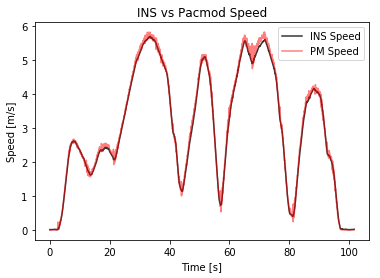

In [3]:
# Plotting

plt.figure()
plt.plot(ins_data.index,ins_data['.mag_speed'],label="INS Speed",alpha=0.8,color='k')
plt.plot(pacmod_speed.index,pacmod_speed['.data'],label="PM Speed",alpha=0.5,color='r')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('INS vs Pacmod Speed')
plt.show();

Text(0.5, 1.0, 'Ins vs. GPS fix data')

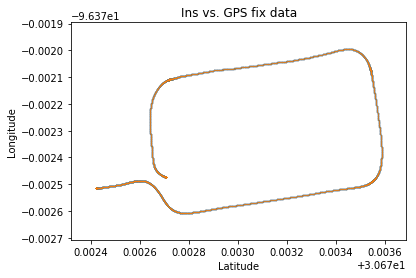

In [4]:
# GPS Plot

plt.figure()
plt.scatter(ins_data['.LLA.x'],ins_data['.LLA.y'],s=0.1,label="INS")
plt.scatter(fix_data['.latitude'],fix_data['.longitude'],s=0.05,label="Fix",alpha=0.5)
plt.xlim([ins_data['.LLA.x'].min()-1e-4,ins_data['.LLA.x'].max()+1e-4])
plt.ylim([ins_data['.LLA.y'].min()-1e-4,ins_data['.LLA.y'].max()+1e-4])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Ins vs. GPS fix data')

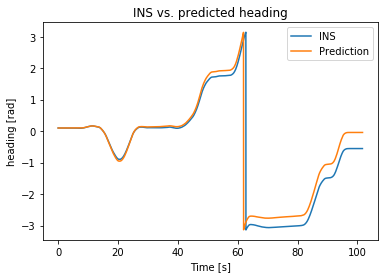

In [5]:
plt.figure()
plt.plot(ins_data.index.values,ins_data['.RPY.z'] * np.pi/180,label='INS') # plot yaw

predicted_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading

for steering,time in zip(pacmod_steer['.manual_input'],pacmod_steer.index):
    V = pacmod_speed.iloc[pacmod_speed.index.get_loc(time,method='nearest')]['.data']
    prediction = predicted_yaw[-1] - (V/3.4)*np.tan(steering/20.0)*0.033 # updated equation. 
    prediction = (prediction + np.pi) % (2* np.pi) - np.pi # Wrap to pi
    predicted_yaw.append(prediction)



plt.plot(pacmod_steer.index,predicted_yaw[0:-1],label='Prediction')
plt.xlabel('Time [s]')
plt.ylabel('heading [rad]')
plt.title('INS vs. predicted heading');
plt.legend()
plt.show();

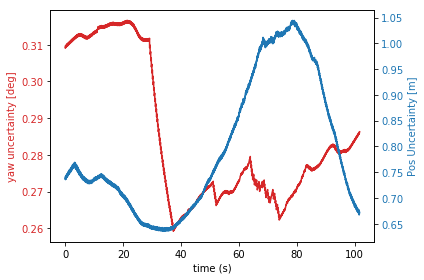

In [6]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('yaw uncertainty [deg]', color=color)
ax1.plot(ins_data.index,ins_data['.YawUncertainty'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pos Uncertainty [m]', color=color)  # we already handled the x-label with ax1
ax2.plot(ins_data.index,ins_data['.PosUncertainty'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [19]:
import plotly.express as px
px.set_mapbox_access_token('pk.eyJ1IjoiYWRhcndlc2giLCJhIjoiY2ozbHpkOXp4MDEzbDMyb3plcnd4dzBsbSJ9.b0nUVzEek7XJeTFjfVqwsw')
fig = px.scatter_mapbox(ins_data, lat=".LLA.x", lon=".LLA.y", color=".PosUncertainty",zoom=17)
fig.show()


